# Bayesian Lasso

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### Example 1

We simulated n = 20 data set to fit models and n = 200 data set
to compare prediction errors of proposed models with eight predictors. We let
$β = (3, 1.5, 0, 0, 2, 0, 0, 0)′$ and $σ = 3$. The pairwise correlation between $x_i$ and $x_j$
was set to be $corr(i, j) = 0.5^{|i−j|}$

In [2]:
# Parameters
n_train = 20  # Number of training samples
n_test = 200  # Number of testing samples
p = 8         # Number of predictors
beta = np.array([3, 1.5, 0, 0, 2, 0, 0, 0])  # True coefficients
sigma = 3     # Standard deviation of noise
correlation_decay = 0.5

# Create covariance matrix based on corr(i, j) = 0.5^|i-j|
cov_matrix = np.fromfunction(
    lambda i, j: correlation_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Generate training predictors (X) and noise
X_train = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_train)
epsilon_train = np.random.normal(loc=0, scale=1, size=n_train)

# Generate training response (y)
y_train = X_train @ beta + sigma * epsilon_train

# Generate testing predictors (X) and noise
X_test = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_test)
epsilon_test = np.random.normal(loc=0, scale=1, size=n_test)

# Generate testing response (y)
y_test = X_test @ beta + sigma * epsilon_test

# Output data
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (20, 8) (20,)
Testing data shape: (200, 8) (200,)


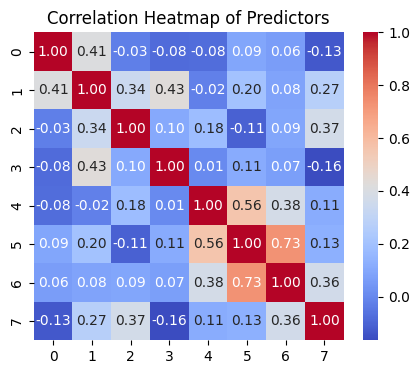

In [3]:
# Calculate correlation matrix for predictors
corr_matrix = np.corrcoef(X_train, rowvar=False)

# Create heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Predictors")
plt.show()


In [4]:
# Example: Fit a simple linear regression model for demonstration
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(lr.intercept_)
print(lr.coef_)
# # Plot true vs predicted
# plt.plot(y_test, label="True Values", alpha=0.7)
# plt.plot(y_pred, label="Predicted Values", alpha=0.7)
# plt.legend()
# plt.title("True vs. Predicted Values")
# plt.xlabel("Sample Index")
# plt.ylabel("Response (y)")
# plt.show()


1.149476037699666
[ 1.6799972   2.80676833  1.39985026 -0.99684208  1.39805157  1.33904544
 -0.37000271 -0.8804416 ]


##### Frequentist Lasso

In [5]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Set lambda (alpha in scikit-learn)
alpha = 0.1  # Regularization parameter

# Fit Lasso regression
lasso = Lasso(alpha=alpha, fit_intercept=True)
lasso.fit(X_train, y_train)

# Predictions
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

# Evaluation
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Frequentist Lasso Results:")
print(f"Train MSE: {mse_train:.3f}")
print(f"Test MSE: {mse_test:.3f}")
print("Coefficients:", lasso.coef_)

Frequentist Lasso Results:
Train MSE: 3.501
Test MSE: 14.373
Coefficients: [ 1.72092487  2.631446    0.76931616 -0.60558046  1.46112726  0.86564987
 -0.01553869 -0.62030459]


##### Bayesian Lasso

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 928 seconds.
There were 389 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


AttributeError: Line2D.set() got an unexpected keyword argument 'credible_interval'

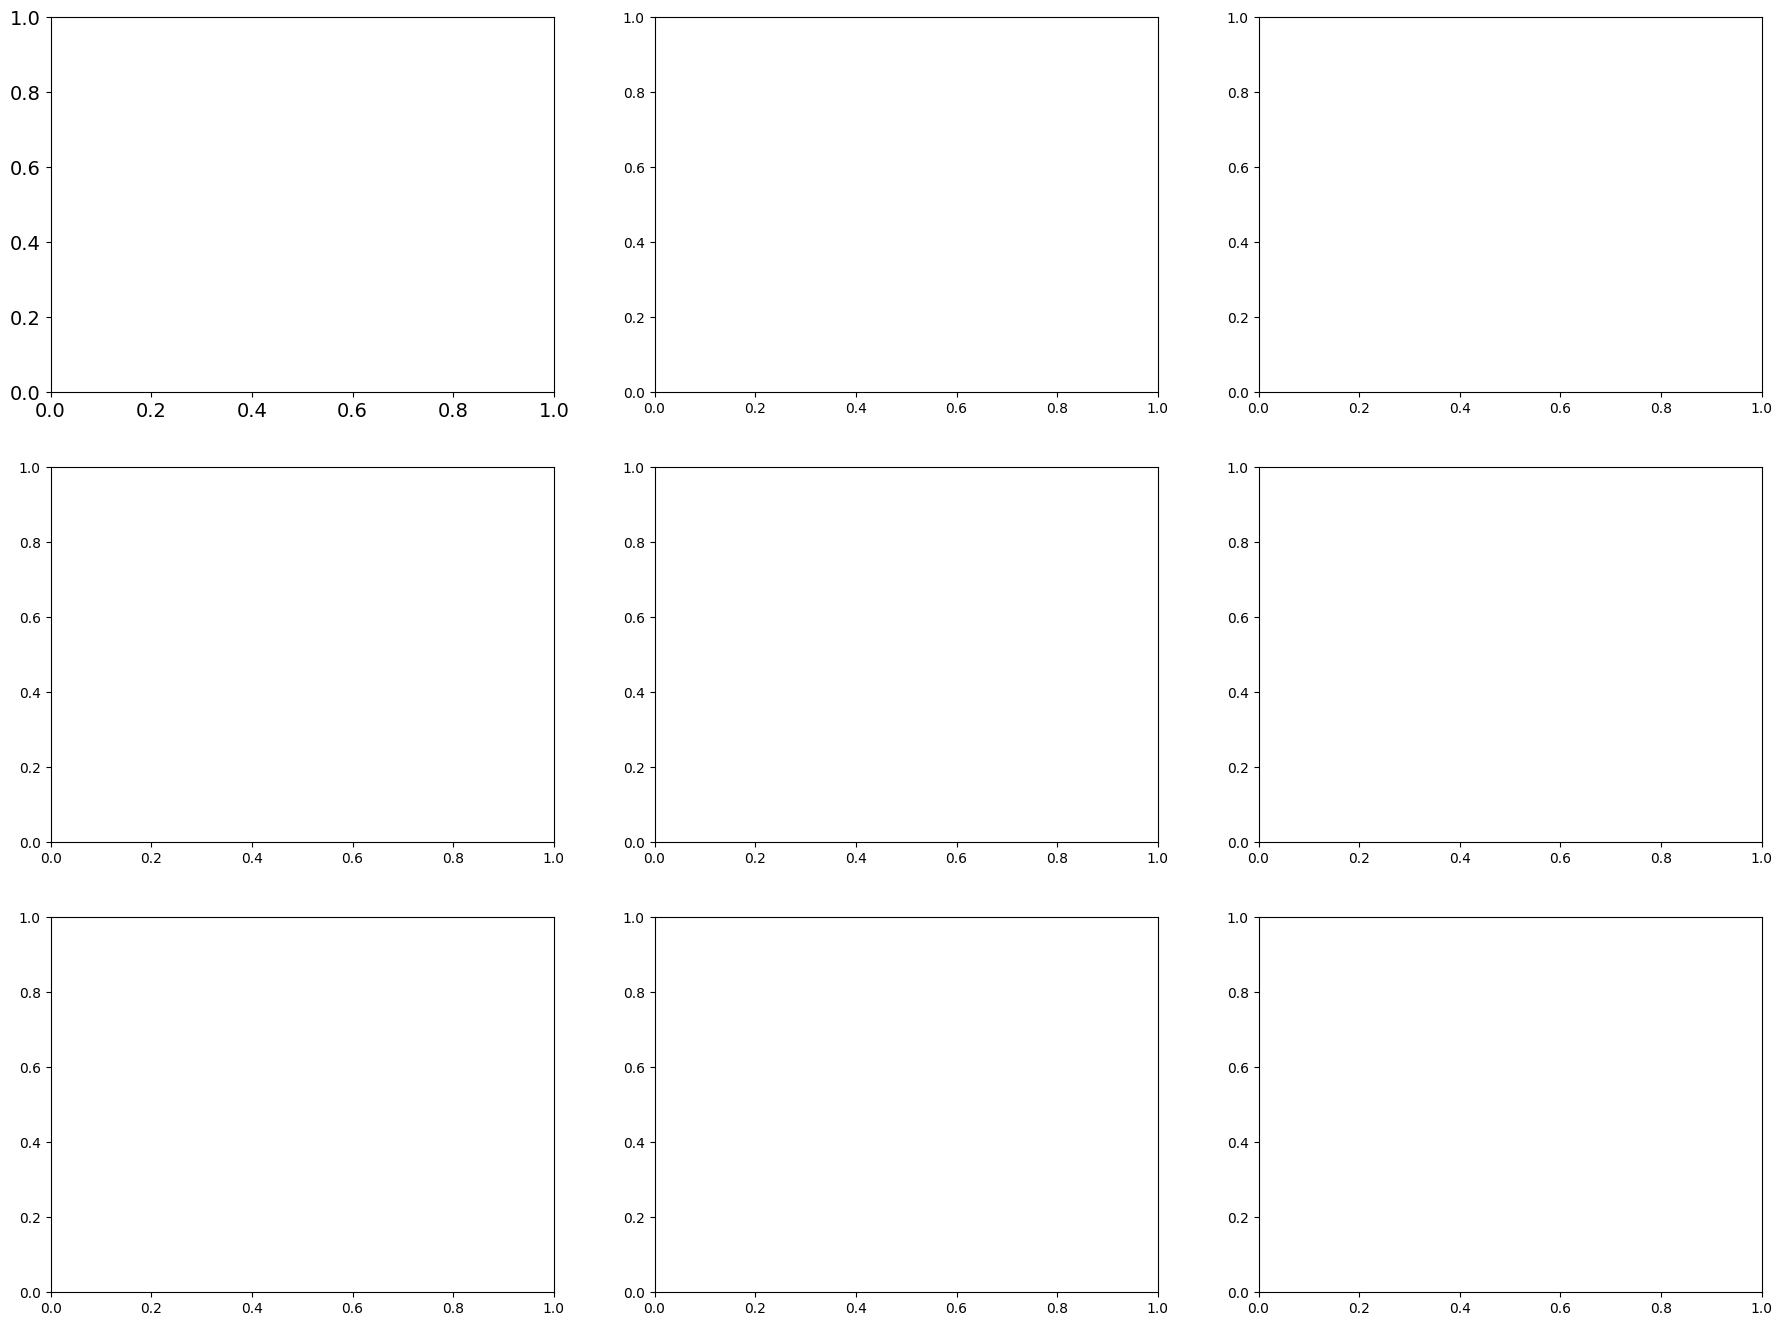

In [6]:
# Hyperparameters for the prior
lambda_prior = 1  # Equivalent to alpha in the Frequentist approach

# Bayesian Lasso Model
with pm.Model() as bayesian_lasso:
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_prior, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Inference
    trace = pm.sample(1000, tune=1000, target_accept=0.9, progressbar=True)

# Posterior summaries
pm.plot_posterior(trace, var_names=["beta", "intercept"], hdi_prob=0.95)
beta_post_mean = trace["beta"].mean(axis=0)
print("Bayesian Lasso Results:")
print("Posterior Means for Coefficients:", beta_post_mean)

In [ ]:
print(trace)
# Access the posterior samples for the coefficients (e.g., beta)
posterior_samples = trace.posterior["beta"]
# print(posterior_samples)
# Get summary statistics for the 'beta' parameter
pm.summary(trace, var_names=["beta"])

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],1.739,0.618,0.573,2.947,0.026,0.019,543.0,1205.0,1.01
beta[1],2.316,0.951,0.654,4.244,0.066,0.054,228.0,74.0,1.03
beta[2],0.456,0.753,-0.724,2.008,0.031,0.022,666.0,1152.0,1.01
beta[3],-0.318,0.623,-1.802,0.567,0.048,0.039,269.0,71.0,1.02
beta[4],1.362,0.686,-0.007,2.497,0.024,0.017,840.0,1337.0,1.01
beta[5],0.674,0.707,-0.399,2.030,0.032,0.022,471.0,1259.0,1.01
beta[6],-0.019,0.448,-0.953,0.862,0.013,0.009,1112.0,1608.0,1.01
beta[7],-0.314,0.511,-1.636,0.365,0.043,0.039,245.0,65.0,1.02


array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n5'}>],
       [<Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n7'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

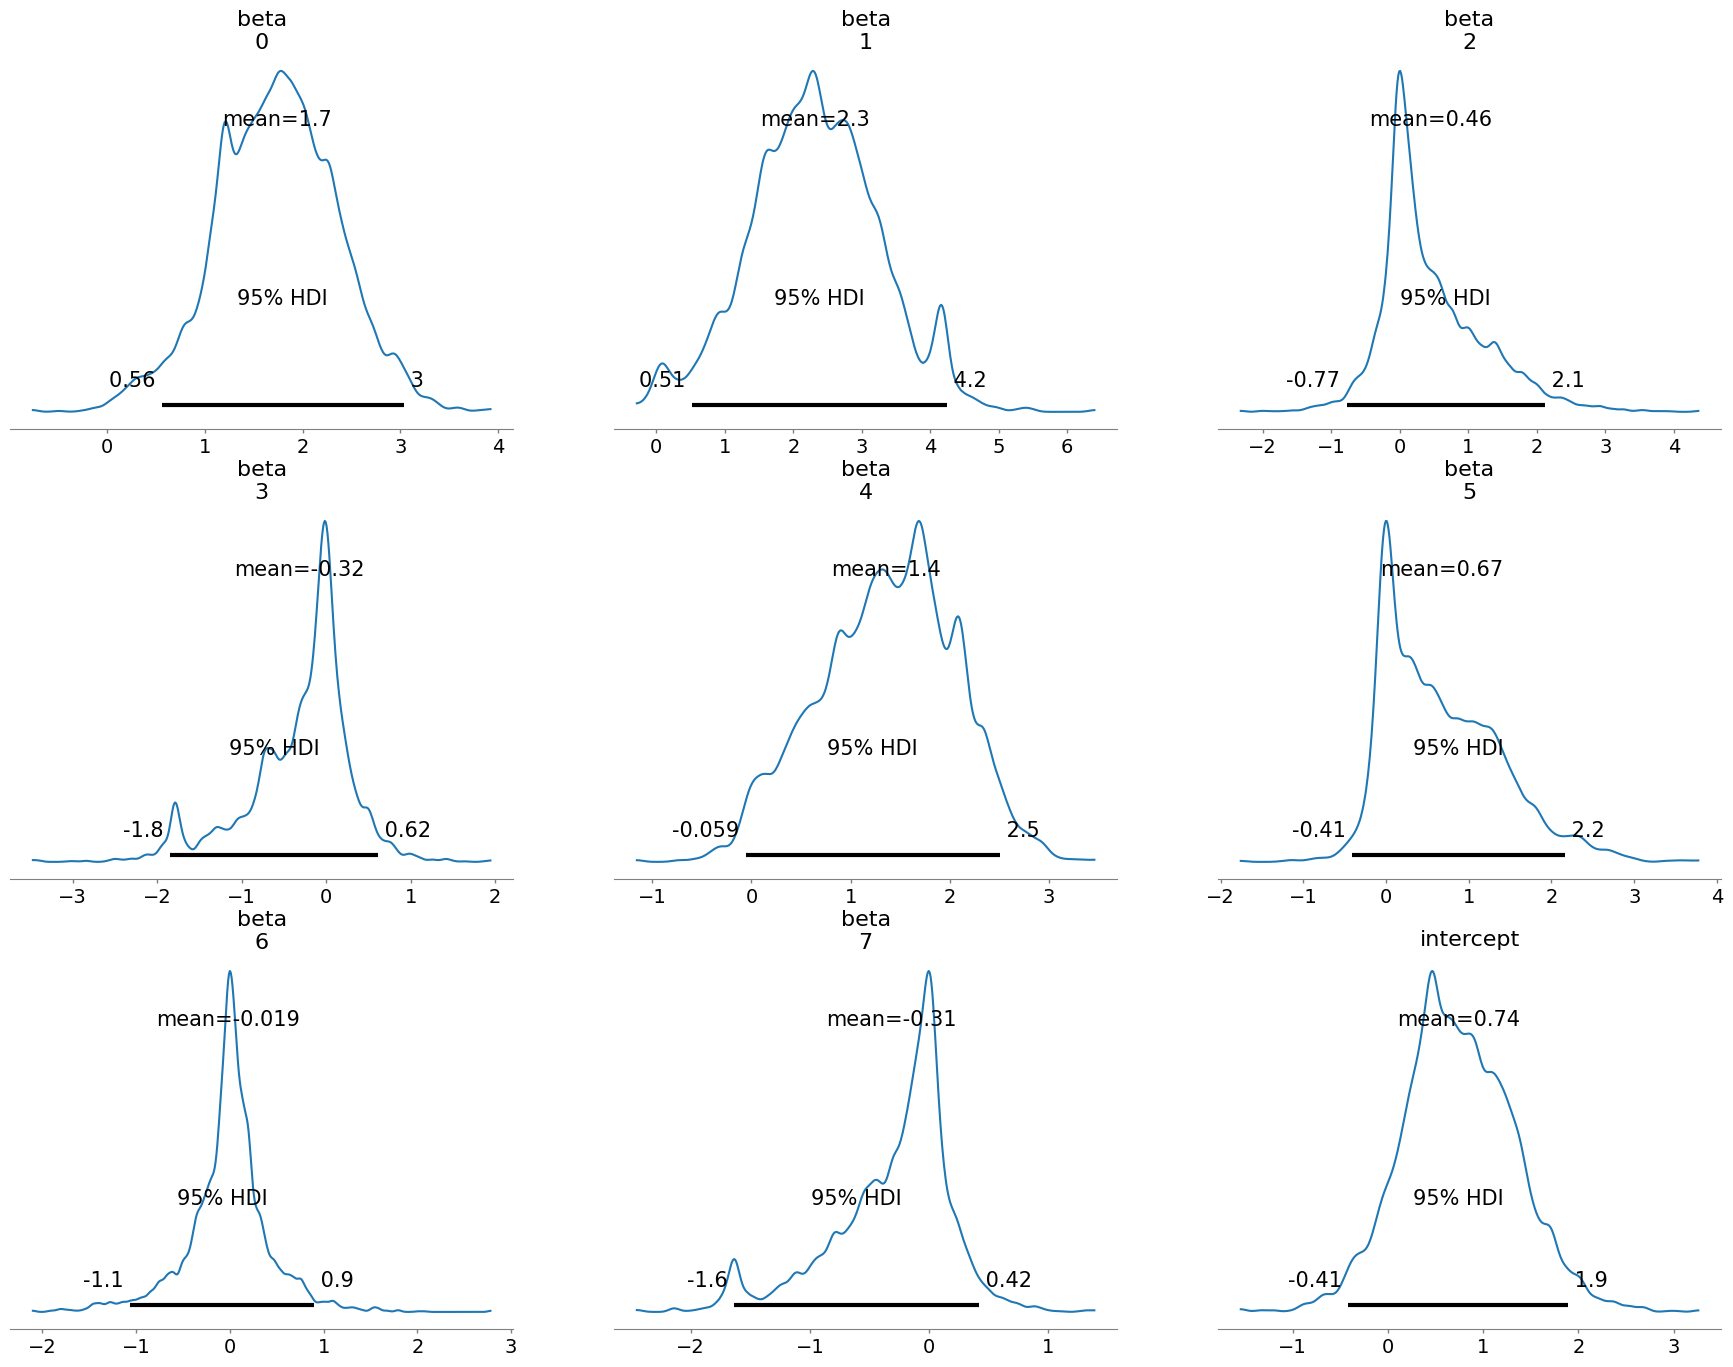

In [16]:
# Posterior summaries
pm.plot_posterior(trace, var_names=["beta", "intercept"], hdi_prob=0.95)

In [ ]:
# Get posterior predictions
with bayesian_lasso:
    posterior_predictive = pm.sample_posterior_predictive(trace) #, var_names=["y"])

# Compute the MSE
y_pred = posterior_predictive["y"].mean(axis=0)  # Mean of the posterior predictive samples
mse = mean_squared_error(y_train, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Retrieve the posterior means for the coefficients
beta_post_mean = trace["beta"].mean(axis=0)
intercept_post_mean = trace["intercept"].mean()
print("Bayesian Lasso Results:")
print("Posterior Means for Coefficients:", beta_post_mean)
print("Posterior Mean for Intercept:", intercept_post_mean)

Sampling: [y]


Output()

KeyError: 'y'